## IMPORT LIBRARIES & DATA

In [1]:
!pip install yellowbrick

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler # skala menjadi 0-1
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.metrics import davies_bouldin_score, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
plt.style.use("fivethirtyeight")

In [3]:
data = pd.read_csv('Dataset-Praktikum (2).csv')
data

,IDPelanggan,Kelamin,Usia,Pendapatan (juta Rp),Rating_pengeluaran (1-100)
0,1,Laki,19,15,39
1,2,Laki,21,15,81
2,3,Perempuan,20,16,6
3,4,Perempuan,23,16,77
4,5,Perempuan,31,17,40
...,...,...,...,...,...
195,196,Perempuan,35,120,79
196,197,Perempuan,45,126,28
197,198,Laki,32,126,74
198,199,Laki,32,137,18


## EDA

In [4]:
data.shape


(200, 5)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   IDPelanggan                 200 non-null    int64 
 1   Kelamin                     200 non-null    object
 2   Usia                        200 non-null    int64 
 3   Pendapatan (juta Rp)        200 non-null    int64 
 4   Rating_pengeluaran (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
data.isnull().sum()

IDPelanggan                   0
Kelamin                       0
Usia                          0
Pendapatan (juta Rp)          0
Rating_pengeluaran (1-100)    0
dtype: int64

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
IDPelanggan,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Usia,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Pendapatan (juta Rp),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Rating_pengeluaran (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [8]:
data.describe(include=['object'])

,Kelamin
count,200
unique,2
top,Perempuan
freq,112


In [9]:
data.drop(columns='IDPelanggan', inplace=True)

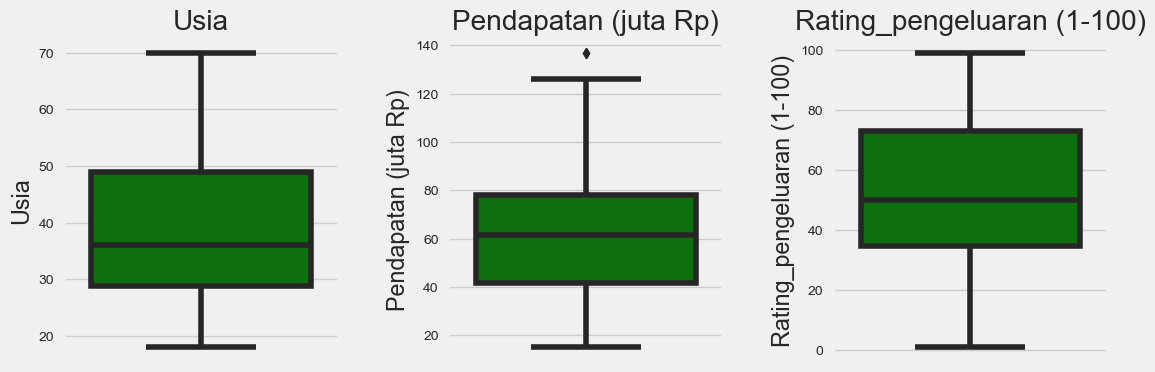

In [10]:
def box_plot(data):
    # definisikan varibel yg akan divisualisasikan
    variables = data.select_dtypes(exclude='object').columns
    
    fig, axes =plt.subplots(1, 3, figsize=(12, 4)) # sesuaikan ukutan figure
    fig.subplots_adjust(hspace=0.4, wspace=0.4) # atur jarak antar subplot
    
    # Membuat figure dan axes untuk subplot dengan ukuran 1x3
    for i, var in enumerate(variables):
        sns.boxplot(y=var, data=data, color="green", ax=axes[i]) 
        axes[i].set_title(var) # menambahkan judul untuk setiap plot
        
    # Tampilkan plot
    plt.show()

box_plot(data)

## PRE-PROCESSING

### ENCODING

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Kelamin'] = le.fit_transform(data['Kelamin'])
data.head()

,Kelamin,Usia,Pendapatan (juta Rp),Rating_pengeluaran (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


### SCALLING

In [12]:
# initiate
scaler = MinMaxScaler()

# fit transform
X_scaled = scaler.fit_transform(data)
X_scaled

array([[0.        , 0.01923077, 0.        , 0.3877551 ],
       [0.        , 0.05769231, 0.        , 0.81632653],
       [1.        , 0.03846154, 0.00819672, 0.05102041],
       [1.        , 0.09615385, 0.00819672, 0.7755102 ],
       [1.        , 0.25      , 0.01639344, 0.39795918],
       [1.        , 0.07692308, 0.01639344, 0.76530612],
       [1.        , 0.32692308, 0.02459016, 0.05102041],
       [1.        , 0.09615385, 0.02459016, 0.94897959],
       [0.        , 0.88461538, 0.03278689, 0.02040816],
       [1.        , 0.23076923, 0.03278689, 0.7244898 ],
       [0.        , 0.94230769, 0.03278689, 0.13265306],
       [1.        , 0.32692308, 0.03278689, 1.        ],
       [1.        , 0.76923077, 0.04098361, 0.14285714],
       [1.        , 0.11538462, 0.04098361, 0.7755102 ],
       [0.        , 0.36538462, 0.04098361, 0.12244898],
       [0.        , 0.07692308, 0.04098361, 0.79591837],
       [1.        , 0.32692308, 0.04918033, 0.34693878],
       [0.        , 0.03846154,

## MODELLING

### 1. K-MEANS

#### Metode Elbow

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows wi

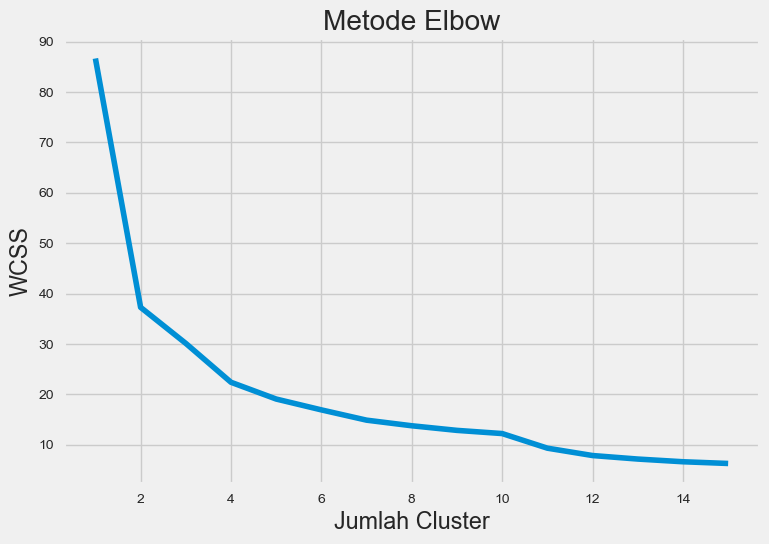

In [13]:
# Menggunakan metode elbow untuk menentukan angka cluster yg tepat
wcss = []
for i in range (1, 16): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range (1, 16), wcss)
plt.title('Metode Elbow')
plt.xlabel('Jumlah Cluster')
plt.ylabel('WCSS')
plt.show()

In [14]:
# Menjalankan K-Means Clustering ke dataset
model1 =  KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_pred1 = model1.fit_predict(X_scaled)

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


#### Visualisasi

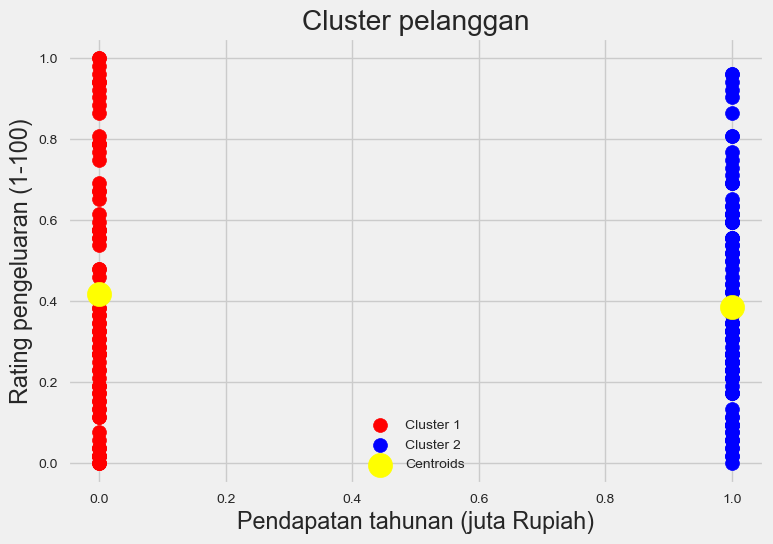

In [15]:
# Visualisasi hasil clusters
plt.scatter(X_scaled[y_pred1 == 0, 0], X_scaled[y_pred1 == 0, 1],
           s =  100, c = 'red', label = 'Cluster 1')

plt.scatter(X_scaled[y_pred1 == 1, 0], X_scaled[y_pred1 == 1, 1],
           s =  100, c = 'blue', label = 'Cluster 2')

plt.scatter(model1.cluster_centers_[:, 0], model1.cluster_centers_[:, 1],
           s =  300, c = 'yellow', label = 'Centroids')

plt.title('Cluster pelanggan')
plt.xlabel('Pendapatan tahunan (juta Rupiah)')
plt.ylabel('Rating pengeluaran (1-100)')
plt.legend()
plt.show()

### 2. DBSCAN

In [16]:
# Membuat objek DBSCAN dengan parameter epsilon dan jumlah minimum sampel
model2 = DBSCAN(eps=1, min_samples = 5)

# Melakukan clustering
model2.fit(X_scaled)

# Mendapatkan label untuk setiap data (-1 menandakan noise)
y_pred2 = model2.labels_
y_pred2

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0], dtype=int64)

In [17]:
data['Hasil_cluster'] = model2.labels_
data.head()

,Kelamin,Usia,Pendapatan (juta Rp),Rating_pengeluaran (1-100),Hasil_cluster
0,0,19,15,39,0
1,0,21,15,81,0
2,1,20,16,6,1
3,1,23,16,77,1
4,1,31,17,40,1


#### Visualisasi

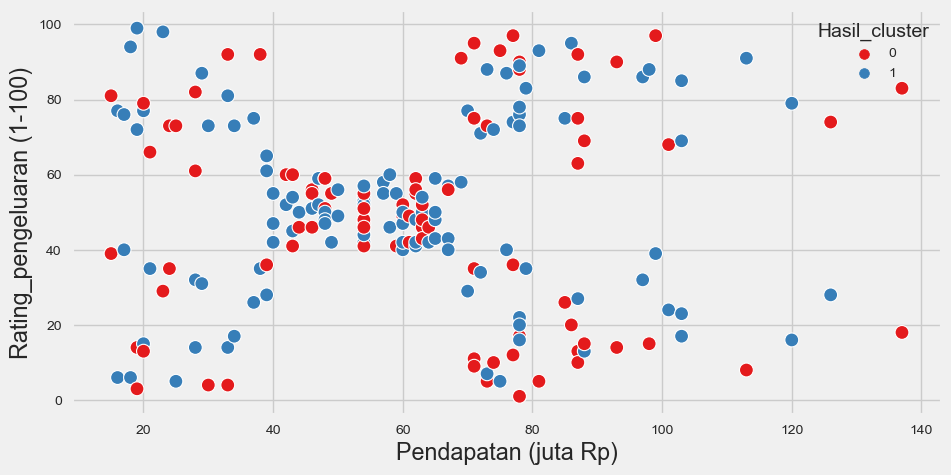

In [18]:
plt.figure(figsize=(10, 5))

sns.scatterplot(x = 'Pendapatan (juta Rp)', y = 'Rating_pengeluaran (1-100)',
               hue = 'Hasil_cluster', data = data, palette = 'Set1', s = 100);

## MATRIKS EVALUASI

### 1. K-MEANS

In [19]:
# Menghitung Silhouette_score algoritma K-Means
Evaluasi_KMeans = silhouette_score(X_scaled, y_pred1)
print("Slihouette Score:", Evaluasi_KMeans)

Slihouette Score: 0.5194624832665107


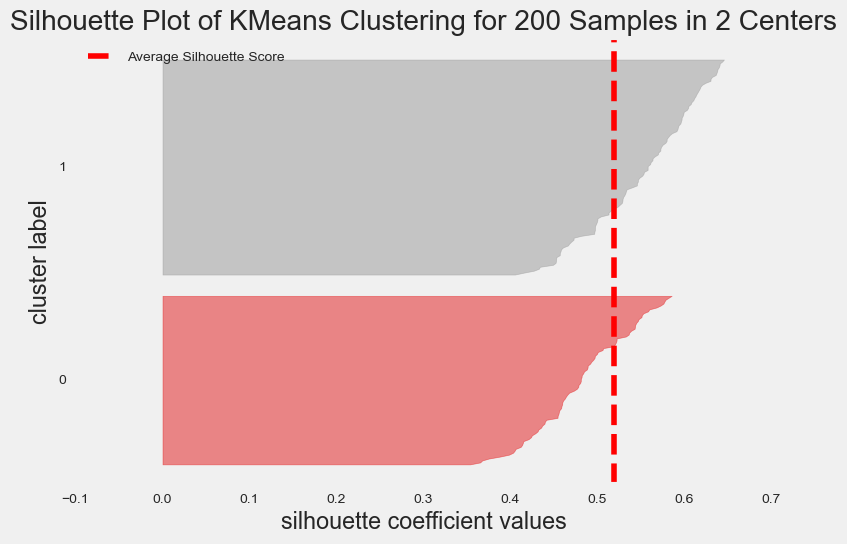

In [20]:
# Membuat Silhouette Visualisation untuk algoritma k-means
silhouette_viz = SilhouetteVisualizer(model1)
silhouette_viz.fit(X_scaled)
plt.grid(False)
silhouette_viz.show()
plt.show()

In [21]:
# silhouette -> jarak antar cluster
# semakin mendekati 0 -> makin bagus

In [22]:
Evaluasi_DBScan = silhouette_score(X_scaled, y_pred1)
print("Silhouette Score:", Evaluasi_DBScan)

Silhouette Score: 0.5194624832665107


### 2. Davies-Bouldin Index (DBI)

In [23]:
# Menghitung Davies-Bouldin Index (DBI) algoritma k-means
dbi_score1 = davies_bouldin_score(X_scaled, y_pred1)
print("Davies-Bouldin Index (DBI):", dbi_score1)

Davies-Bouldin Index (DBI): 0.8172534497318451


In [24]:
# Menghitung Davies-Bouldin Index (DBI) algoritma db-scan
dbi_score2 = davies_bouldin_score(X_scaled, y_pred2)
print("Davies-Bouldin Index (DBI):", dbi_score2)

Davies-Bouldin Index (DBI): 0.8172534497318451


Hal yang bisa dilakukan untuk improve model performance? **Hyperparameter tuning**
- Grid Search
- Random Search
- Bayesian Search
- PSO
- GWO, etc.